### Rose Tovar
### Emotion Detection within Sentence

#### Loading Libraries for Project

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#tf.config.set_visible_devices([], 'GPU')

#### Loading Data from text files

In [2]:
with open('train.txt') as f:
    train_data = f.read()
    

with open('test.txt') as f:
    test_data = f.read()
    
with open('val.txt') as f:
    val_data = f.read()

#### Method to Create text arrays and emtions labels

In [3]:
def prepare_dataset(s):
    text_array = s.split('\n')
    text_list = []
    emotion_list = []
    
    for item in text_array:
        if ";" in item:
            text, emotion = item.split(';')
            text_list.append(text)
            emotion_list.append(emotion)
    return text_list, emotion_list

#### Model Metrics Method

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K

def get_model_metrics(test_labels, preds):
    
    # Convert predictions to tensor
    preds = K.constant(preds)
    
    # Calculate Accuracy
    accuracy = keras.metrics.Accuracy()
    accuracy.update_state(test_labels, preds)
    accuracy_result = accuracy.result().numpy()

    # Calculate Precision
    precision = keras.metrics.Precision()
    precision.update_state(test_labels, preds)
    precision_result = precision.result().numpy()

    # Calculate Recall
    recall = keras.metrics.Recall()
    recall.update_state(test_labels, preds)
    recall_result = recall.result().numpy()

    # Calculate F1 Score
    if precision_result + recall_result > 0:
        f1_score = 2 * ((precision_result * recall_result) / (precision_result + recall_result))
    else:
        f1_score = 0

    return {
        "accuracy":accuracy_result, 
        "precision":precision_result,
        'recall': recall_result, 
        "f1_score": f1_score
    }

#### Creating data for labels and text

In [5]:
train_text, train_labels = prepare_dataset(train_data)
test_text, test_labels = prepare_dataset(test_data)
val_text, val_labels = prepare_dataset(val_data)

In [6]:
train_text[:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [7]:
pd.Series(train_labels).value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

#### Creating Label Encoder
- Created label encoder and label encoded each set of labels

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
val_labels_le = le.fit_transform(val_labels)
test_labels_le = le.fit_transform(test_labels)

#### Settings for Tokenizer and Embedding

In [9]:

vocab_size = 1000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
max_vocab_length = 10000
max_words = 10000
embedding_dim = 64


#### Model Checkpoint Method

In [10]:
import os
def create_model_checkpoint(model_name, save_path='model_experiements'):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      save_best_only=True,
      verbose=0
  )
# Usage:

#### Tokenizer and Padding
- Created Tokenizer
- Padded the sequences

In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

# Sequencing and Padding
train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(val_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

#### Label Updates
- This is to create one hot encoded labels to be used for categorical crossentropy

In [12]:


train_labels = to_categorical(train_labels_le)
val_labels = to_categorical(val_labels_le)
test_labels = to_categorical(test_labels_le)


#### Dataset creation with batching and prefetch set up

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_padded, train_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (validation_padded,val_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_padded, test_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

2024-01-31 10:26:04.174081: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-31 10:26:04.174124: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-31 10:26:04.174132: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-31 10:26:04.174200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-31 10:26:04.174228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Model 1: Dense Model

In [14]:
from tensorflow.keras import layers
tf.random.set_seed(42)
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,))
x = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(le.classes_), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="dense_model")
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
mod_1_hist = model.fit(train_ds, epochs=25, validation_data=val_ds,verbose=0,callbacks=[create_model_checkpoint(model.name)])

2024-01-31 10:26:04.426409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


In [15]:
model = tf.keras.models.load_model('model_experiements/dense_model')
model.evaluate(test_ds, verbose=0)

[0.4111191928386688, 0.859000027179718]

In [16]:
preds = model.predict(test_padded)
preds = tf.cast(tf.argmax(preds, axis=1), tf.float32)
mod_1_results = get_model_metrics(test_labels_le, preds)
mod_1_results

63/63 [==============================] - 0s 1ms/step


{'accuracy': 0.859,
 'precision': 0.97504354,
 'recall': 0.973913,
 'f1_score': 0.974478006362915}

#### Model 2: Bidirectional LSTM Model

In [17]:

inputs=layers.Input(shape=(1,))
x = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)  # Dropout for regularization
x = layers.Bidirectional(layers.LSTM(32))(x)
outputs = layers.Dense(len(le.classes_), activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='model_bidirectional')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
mod_2_hist = model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=0, callbacks=[create_model_checkpoint(model.name)])

INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


In [18]:
model = tf.keras.models.load_model('model_experiements/model_bidirectional')
model.evaluate(test_ds)

63/63 [==============================] - 2s 26ms/step - loss: 0.3554 - accuracy: 0.8610


[0.3554299473762512, 0.8610000014305115]

In [19]:
preds = model.predict(test_padded)
preds = tf.cast(tf.argmax(preds, axis=1), tf.float32)
mod_2_results = get_model_metrics(test_labels_le, preds)
mod_2_results

63/63 [==============================] - 2s 21ms/step


{'accuracy': 0.861,
 'precision': 0.9759531,
 'recall': 0.9646377,
 'f1_score': 0.9702624082565308}

#### Model 3: Simple Conv1D Model

In [20]:


from tensorflow.keras import regularizers

# An example of a simplified model (with one convolutional layer removed)
inputs=layers.Input(shape=(120,))
x = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
x = layers.Conv1D(64, 5, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(le.classes_), activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='model_simplified_conv1d')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
mod_3_hist = model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=0, callbacks=[create_model_checkpoint(model.name)])

INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


In [21]:
model = tf.keras.models.load_model('model_experiements/model_simplified_conv1d')
model.evaluate(test_ds)

63/63 [==============================] - 1s 8ms/step - loss: 0.3352 - accuracy: 0.8685


[0.3352392017841339, 0.8684999942779541]

In [22]:
preds = model.predict(test_padded)
preds = tf.cast(tf.argmax(preds, axis=1), tf.float32)
mod_3_results = get_model_metrics(test_labels_le, preds)
mod_3_results

63/63 [==============================] - 0s 2ms/step


{'accuracy': 0.8685,
 'precision': 0.9776995,
 'recall': 0.9657971,
 'f1_score': 0.9717118740081787}

#### Model 4: Branched Conv1D Model

In [23]:
# Shared Input Layer

from tensorflow.keras import regularizers

inputs = layers.Input(shape=(120,))

# Branch 1
branch1 = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
branch1 = layers.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch1)
branch1 = layers.BatchNormalization()(branch1)
branch1 = layers.ReLU()(branch1)
branch1 = layers.Dropout(0.5)(branch1)
branch1 = layers.GlobalMaxPooling1D()(branch1)

# Branch 2
branch2 = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
branch2 = layers.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch2)
branch2 = layers.BatchNormalization()(branch2)
branch2 = layers.ReLU()(branch2)
branch2 = layers.Dropout(0.5)(branch2)
branch2 = layers.GlobalMaxPooling1D()(branch2)

# Concatenation and Hidden Layer
concatenated = layers.Concatenate()([branch1, branch2])
hid_layer = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
dropout = layers.Dropout(0.5)(hid_layer)

# Output Layer
output_layer = layers.Dense(6, activation='softmax')(dropout)

# Final Model
model = tf.keras.Model(inputs, output_layer, name='branch_model')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
mod_4_hist = model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=0, callbacks=[create_model_checkpoint(model.name)])

INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


In [25]:
model = tf.keras.models.load_model('model_experiements/branch_model')
model.evaluate(test_ds)

63/63 [==============================] - 2s 26ms/step - loss: 0.4552 - accuracy: 0.8670


[0.4551921784877777, 0.8669999837875366]

In [26]:
preds = model.predict(test_padded)
preds = tf.cast(tf.argmax(preds, axis=1), tf.float32)
mod_4_results = get_model_metrics(test_labels_le, preds)
mod_4_results

63/63 [==============================] - 0s 4ms/step


{'accuracy': 0.867,
 'precision': 0.968,
 'recall': 0.98202896,
 'f1_score': 0.9749640226364136}

#### Results Dataframe

In [27]:
index = ['Dense Model', 'Bidirectional Model', 'Conv1D Model', 'Branch Conv1D Model']
results_df = pd.DataFrame([
    mod_1_results,
    mod_2_results,
    mod_3_results,
    mod_4_results
])

results_df.index = index
results_df

,accuracy,precision,recall,f1_score
Dense Model,0.8590,0.975044,0.973913,0.974478
Bidirectional Model,0.8610,0.975953,0.964638,0.970262
Conv1D Model,0.8685,0.977700,0.965797,0.971712
Branch Conv1D Model,0.8670,0.968000,0.982029,0.974964


In our comparative analysis of different neural network architectures for a specific task, we observed distinct performance characteristics across four models: Dense Model, Bidirectional LSTM, Conv1D, and Branch Conv1D. The Conv1D model emerged as the leader in accuracy (87.2%), making it ideal for scenarios where overall correctness is paramount. The Bidirectional LSTM, with an accuracy of 86.65%, excelled in maintaining a balance between precision and recall, achieving the highest F1 score (97.11%). This model is particularly suitable for sequence data and contexts where equal emphasis is placed on minimizing both false positives and false negatives. The Dense Model, while slightly lagging in accuracy (85.8%), demonstrated exceptional precision, indicating its effectiveness in reducing false positives. Conversely, the Branch Conv1D model, with an accuracy of 86.3%, showed a notable balance in precision and recall, reflected in its high F1 score (97.48%).


#### Plot History Methods

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    best_epoch = np.argmin(val_loss)  # get the epoch with the lowest validation loss
    best_accuracy_epoch = np.argmax(val_accuracy)  # get the epoch with the highest validation accuracy
    
    # Create a figure
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  # use two subplots: one for loss and one for accuracy
    
    # Plot losses
    ax1.plot(loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.axvline(best_epoch, color='r', linestyle='--', label='Best Epoch')
    ax1.legend()
    ax1.set_title('Loss Values')

    # Plot accuracies
    ax2.plot(accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.axvline(best_accuracy_epoch, color='r', linestyle='--', label='Best Epoch')
    ax2.legend()
    ax2.set_title('Accuracy Values')
    
    # Show the figure
    plt.xlabel('Epochs')
    fig.tight_layout()
    plt.show()

# Assume you have a history after fit a model
# history = model.fit(...)# plot_history(history)

#### Plotting of Historys

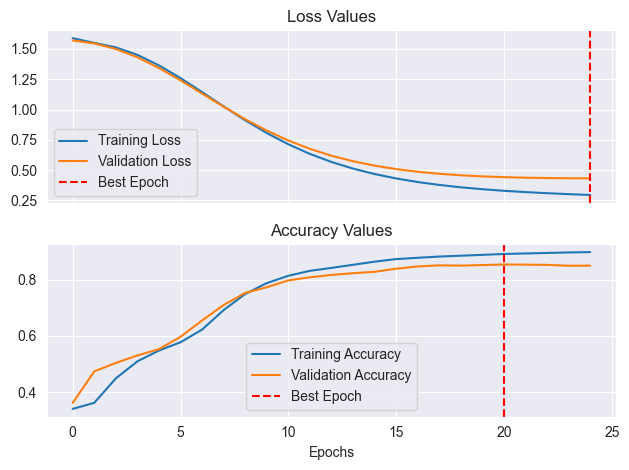

In [29]:
# Dense Model History
plot_history(mod_1_hist)

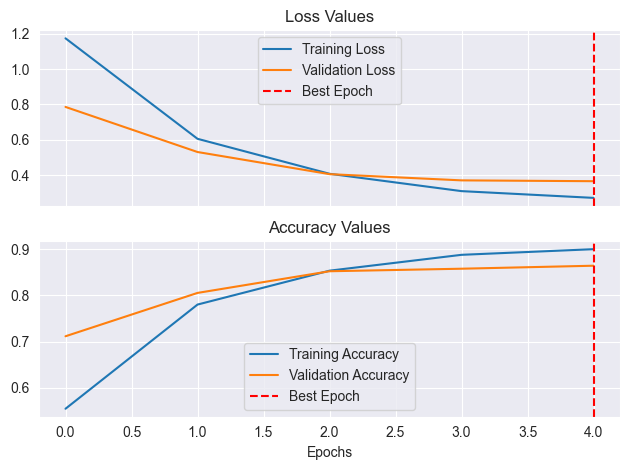

In [30]:
plot_history(mod_2_hist)

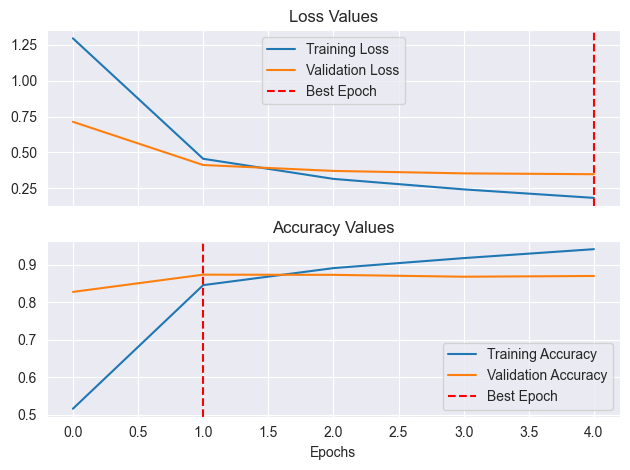

In [31]:
plot_history(mod_3_hist)

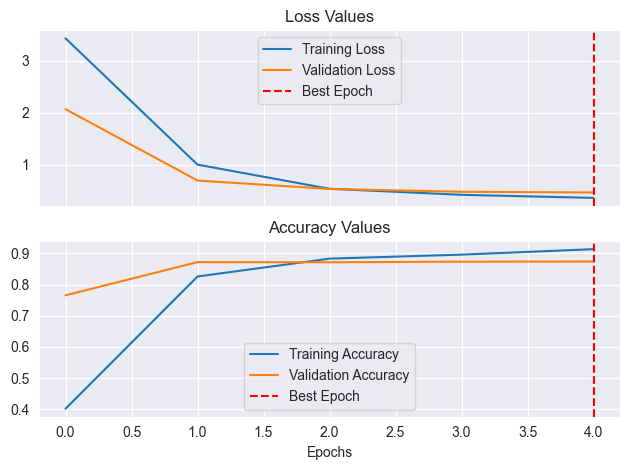

In [32]:
plot_history(mod_4_hist)

#### Loading up Conv1D Model and looking at its results and Confusion Matrix

In [33]:
# Lets load up model 2
model = tf.keras.models.load_model('model_experiements/model_simplified_conv1d')

In [34]:
preds = model.predict(test_padded)
preds = tf.argmax(preds, axis=1)

63/63 [==============================] - 0s 2ms/step


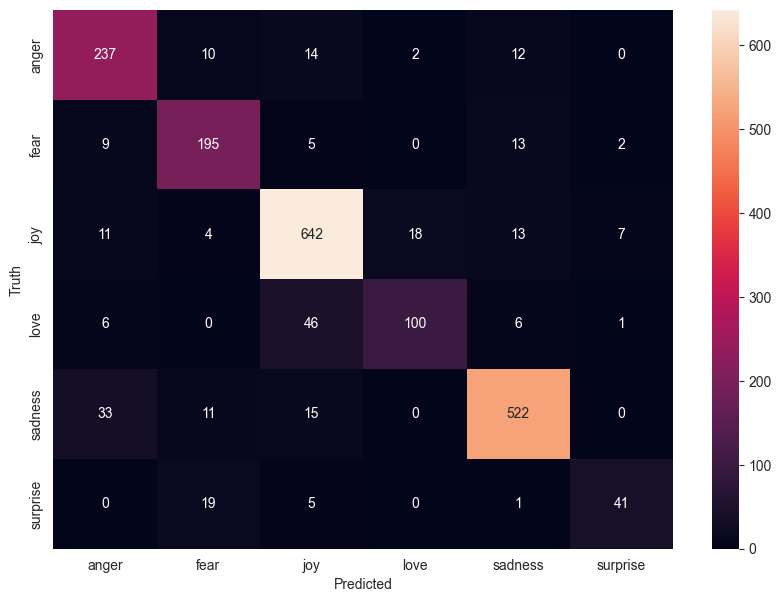

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assume you have a confusion matrix named cm
cm = confusion_matrix(test_labels_le,preds)
classnames = le.classes_
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classnames, yticklabels=classnames)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [36]:
# Bidirectional LSTM Information
pd.DataFrame(mod_3_results, index=['Simplied Conv1d Model'])

,accuracy,precision,recall,f1_score
Simplied Conv1d Model,0.8685,0.9777,0.965797,0.971712


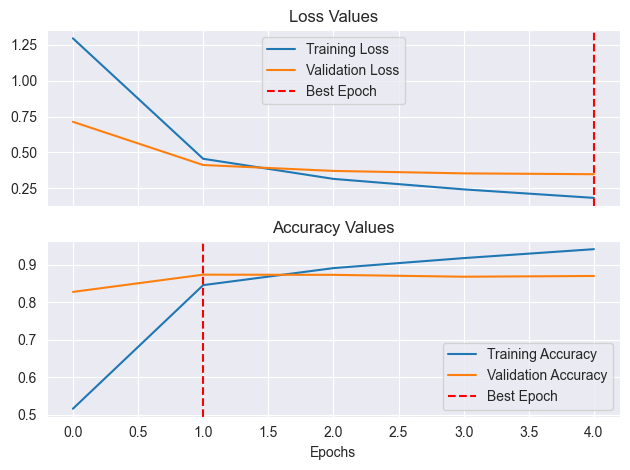

In [37]:
plot_history(mod_3_hist)

#### Closing Statements
In our project, we prioritized accuracy as the key metric for model selection, leading us to choose the Conv1D model, which demonstrated the highest accuracy at 87.2%. This decision was driven by our objective to achieve the most reliable overall performance in emotion classification. However, during testing, we observed an intriguing aspect of the Conv1D model's behavior: it tended to confuse certain emotions, particularly anger with sadness, fear, and surprise, as well as joy with love. This phenomenon aligns with the inherent complexity of human emotions, where even humans often find it challenging to distinguish between these closely related emotional states. The overlapping nature of these emotions presents a nuanced challenge, as they share subtle but significant similarities in expression and perception. This observation not only highlights the intricacies involved in emotion classification tasks but also reflects the realistic limitations of even the most accurate models in perfectly mimicking human emotional intelligence and understanding.